In [119]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpdbuymtc6/pubring.gpg' created
gpg: /tmp/tmpdbuymtc6/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [120]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import sys
sys.path.append('drive/cyclegan_proj')

In [0]:
#from loss import compute_loss
from loss import compute_combined_loss
from loss import conserve_loss
import networks as net
from data_sampler import data_sampler
from utl import *

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import clear_output

In [0]:
input_nc = 1
output_nc = 1
discr_filters = 4
max_power = 2
n_layers = 1
norm_lay = nn.BatchNorm2d
start_size = 28
gen_filters = 4
dropout = None
n_blocks = 1
batch_size = 1
alpha = 5

In [0]:
train_pull = pd.read_csv("drive/cyclegan_proj/train_pull.csv", 
                         header=None).values
train_top = pd.read_csv("drive/cyclegan_proj/train_top.csv",
                        header=None).values

In [0]:
discr_a = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size
).cuda()

discr_b = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size
).cuda()

gener_a = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
).cuda()

gener_b = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
).cuda()

In [114]:
gener_a.apply(weights_init)
gener_b.apply(weights_init)
discr_a.apply(weights_init)
discr_b.apply(weights_init)
print("weights initialized")

weights initialized


In [0]:
opt_gener_a = torch.optim.RMSprop(gener_a.parameters(), lr=0.005)
opt_gener_b = torch.optim.RMSprop(gener_b.parameters(), lr=0.005)
opt_discr_a = torch.optim.RMSprop(discr_a.parameters(), lr=0.005)
opt_discr_b = torch.optim.RMSprop(discr_b.parameters(), lr=0.005)
# from itertools import chain
# a_opt = torch.optim.SGD(chain(gener_a.parameters(), discr_a.parameters()), lr=0.001)
# b_opt = torch.optim.SGD(chain(gener_b.parameters(), discr_b.parameters()), lr=0.001)
#gener_opt = torch.optim.SGD(chain(gener_a.parameters(), gener_b.parameters()), lr=0.001)
#discr_opt = torch.optim.SGD(chain(discr_a.parameters(), discr_b.parameters()), lr=0.001)

In [0]:
ga_loss_log = []
gb_loss_log = []
da_loss_log = []
db_loss_log = []

In [0]:
clambda = 1

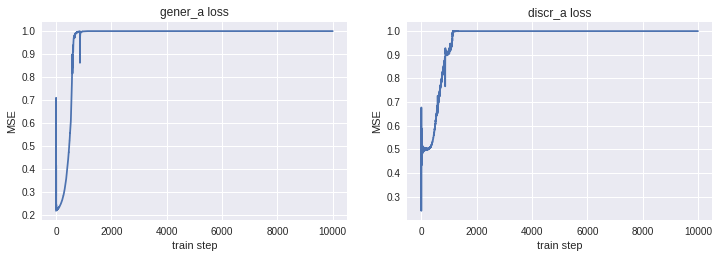

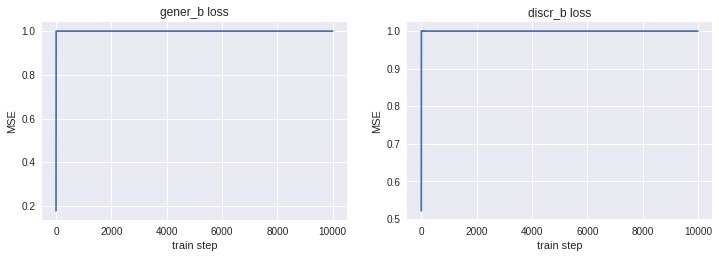

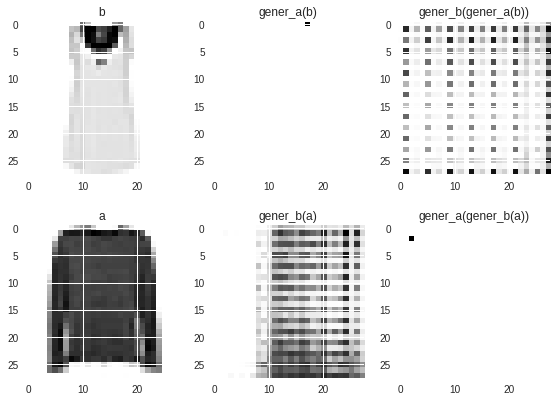

In [118]:
for i in range(10000):
    batch_a, batch_b = data_sampler(batch_size, train_pull, train_top, 
                                    use_gpu=True, requires_grad=True)
    batch_a = batch_a.view(-1, 1, 28, 28).float()
    batch_b = batch_b.view(-1, 1, 28, 28).float()
    
    train_stage(gener_a, gener_b, discr_a, discr_b)
    
    losses = compute_combined_loss(
        gener_a, gener_b,
        discr_a, discr_b,
        batch_a, batch_b,
        alpha,
        discr_loss = 'mse',
        use_gpu=True
    )

    discr_loss, gener_loss = losses[0:2]
    da_loss, db_loss = losses[2:4]
    ga_loss, gb_loss = losses[4:6]
    ga_fool, gb_fool = losses[6:8]

    
    discr_a_mega_loss = da_loss - clambda * conserve_loss(da_loss, discr_a)
    discr_b_mega_loss = db_loss - clambda * conserve_loss(db_loss, discr_b)
    gener_a_mega_loss = ga_loss - clambda * conserve_loss(ga_loss, gener_a)
    gener_b_mega_loss = gb_loss - clambda * conserve_loss(gb_loss, gener_b)
    
    opt_gener_a.zero_grad()
    opt_gener_b.zero_grad()
    opt_discr_a.zero_grad()
    opt_discr_b.zero_grad()

    (-discr_a_mega_loss).backward(retain_graph=True)
    (-discr_b_mega_loss).backward(retain_graph=True)
    (-gener_a_mega_loss).backward(retain_graph=True)
    (-gener_b_mega_loss).backward()

    opt_gener_a.step()
    opt_gener_b.step()
    opt_discr_a.step()
    opt_discr_b.step()
    
    ga_loss_log.append(ga_fool.data[0])
    gb_loss_log.append(gb_fool.data[0])
    da_loss_log.append(da_loss.data[0])
    db_loss_log.append(db_loss.data[0])
    
    
    if (i+1) % 100 == 0:
      print("step {}".format(i+1))
    
    if (i+1) % 500 == 0:
      clear_output()
      visualize_loss(da_loss_log, db_loss_log, ga_loss_log, gb_loss_log,
                     exp_window=None)

      ind = np.random.randint(0, batch_size, 1, dtype=int)[0]
      sample_a, sample_b = data_sampler(1, train_pull, train_top, use_gpu=True)
      plot_geners(sample_a, sample_b, gener_a, gener_b)